## Risk parity strategy

Prepared by Jirong Huang (jironghuang88@gmail.com)

## Disclaimer

None of the contents constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory services. 
Past performance is no indicator of future performance. 
Provided for informational purposes only. 
All investments involve risk, including loss of principal.

Note:
    
- I have a vested interest in this strategy. In fact, this forms my core portfolio.
- Variant of the strategy has been deployed since start of 8-Sep-2020 using my infrastructure here (https://medium.com/datadriveninvestor/designing-and-building-a-fully-automated-algorithmic-trading-portfolio-management-system-6945c6c87620)
- Out-of-sample live results could be found in following link: https://jironghuang.github.io/portfolio/portfolio/ 


## Summary

In the 3 different configurations of risk parity portfolio that I explored (daily correlation matrix, weekly correlation matrix, weekly correlation matrix of alternate asset groupings),the performance characteristics are similar with sharpe between 1.7 to 1.9, annualized returns of 0.16-0.17, calmar ratio of 1.0 to 1.5, sortino of 2.4 to 2.7.

Note: Above corresponds to 10% volatility target and max leverage cap of 2.0. In my simulation, I find that this corresponds to the best sharpe, sortino, least negative skew and kurtosis.

I do not expect such outstanding performance to persist for decades. Based on the literature, sharpe is likely to be closer to 0.8 to 1.0.

## Motivation

This strategy is explored in a different way from other strategies I developed. Instead of carrying out robust statistical techniques such as bootstrapping, block-boostrapping, monte carlo and cross validation to gauge the viability of the strategy, the construction of portfolio is heavily influenced by the literature, white papers and books of hedge funds (e.g. AQR and Bridgewater) and reputable quants. In addition, the data history for my ETFs are pretty limited (dated till 2015); hence carrying out any form of robust statistical test is likened to data snooping.  

In this study, I seek to create an all-weather low maintenance portfolio that could survive all economic regimes in the short and long term. Risky parity all weather portfolio has been studied extensively; and in numerous studies (see References), it was shown to perform better than a 60% equities - 40% bonds portfolio. 

## Approach

1. In the selection of asset classes, I focus on the ones that can survive across 4 economic regimes (see Bridgewater's whitepaper here https://www.bridgewater.com/research-and-insights/the-all-weather-story),

- Rising growth & Rising inflation: Equities, Commodities, Corporate Credit, Inflation linked bonds
- Rising growth & Falling inflation: Equities, Nominal bonds
- Declining growth & Rising inflation: Inflation linked bonds, Commodities
- Declining growth & Falling inflation: Nominal Bonds

2. My world view: In the intermediate to long term, US and China will command global share of economic growth. And the growth will be driven by the technology sections. You will notice this view in the split within the asset classes.

3. Next, I map the regimes into 3 asset classes,

### Asset class 1: Bonds and Inflation protected bonds

- TIP: US treasury inflation protected bonds
- WIP: Global treasury inflation protected bonds
- CBON: China bonds. As noted by Bridgewater (https://www.bridgewater.com/research-and-insights/the-opening-of-chinese-credit-markets-means-that-foreign-investors-can-build-a-balanced-portfolio-in-china-this-will-be-a-big-deal), China bonds offer huge diversification advantages because of its low correlation to rest of the world in terms of growth and inflation. In the actual deployment of the model CNYB.AS is used instead of CBON because of larger AUM and liquidity. But in backtesting, CBON is used instead because of longer data history. Both tickers exhibit high correlation to each other with similar trajectory.
- BNDX: Global nominal investment grade bonds.

* Notice that I omitted US treasury bonds despite its stellar performance over the past few years. US treasury bonds price appreciation is inversely related to interest rates. With rates at rock bottom, I do not see any price appreciation in US bonds in the intermediate to long term. According to Bridgewater (https://www.bloomberg.com/news/articles/2020-04-15/ray-dalio-says-investors-would-be-crazy-to-hold-bonds-now), there is an asymmetric payoff in this asset class with the massive interest rate risk.

### Asset class 2: Stocks

- VT: Global stocks
- EEM: Emerging market stocks
- SPY: US stocks
- MCHI: China stocks
- IXN: Global tech stocks (excluding China)
- KWEB: China tech stocks

### Asset class 3: Gold

- GLD: Gold etf
- IAU: Gold etf

4. Within each of the asset class, I find the risk parity weights i.e. the returns stream volatility contribution to the overall volatility of the asset class.

5. Then, I find the risk parity weights of the asset class returns stream to the overall portfolio.

* Currently, daily correlation matrix is used in production, but I may switch to weekly correlation matrix because of greater stability as advocated by ex MAN-AHL quant Robert Carver (https://qoppac.blogspot.com/2020/11/improving-use-of-correlations-in.html). This requires further research.

6. Overall portfolio realized volatility over last 36 days is capped at 10%. In 1 of my articles (https://medium.com/the-innovation/could-volatility-targeting-increase-risk-adjusted-returns-for-quantitative-strategies-ed9563d5fe5c), I found that volatility targeting could improve risk-adjusted returns, calmar ratio, reduce negative skewness and kurtosis.  

7. Next, in my event-driven backtesting, I imposed the following constraints and parameters,

- window = 252 #If daily correlation matrix is used
- window_week = 52  #If weekly correlation matrix is used
- volatility_targeting = 0.1  #Portfolio volatility target
- volatility_targeting_lookback = 36  #Number of days used to calculate realized exponential volatility
- max_leverage = 2.0  #Maximum leverage is capped at 2.         
- perc_diff_before_rebalancing = 0.15  #% difference between current position and optimal position before rebalancing. Lower % will trigger frequent reblancing and incur more commissions
- comm_fee = 2 #Commission fee of 2 dollars per trade
- financing_fee = 0.015 #Financing fee for leverage used.

8. Then, I simulate the leverage & volatility target to understand its impact on the following performance characteristics,

- Sharpe
- Sortino
- Annualized compounded returns
- Max drawdown
- Kurtosis
- Skewness

9. Lastly, I explore an alternate grouping of asset classes as follow,

asset_class_dict_alt =  {'asset_class1': ['CBON','GLD','TIP', 'WIP'],
                         'asset_class2': ['EEM','MCHI','VT','SPY', 'IXN', 'KWEB']}
                         
- asset_class 1: China bonds + Commodities + Inflation
- asset_class 2: Equities

- Groupings of tickers are partly influenced by newfound research, https://blog.thinknewfound.com/2017/11/risk-parity-much-data-use-estimating-volatilities-correlations/
- And the warnings by Bridgewater surrounding current low interest rate environment risk (https://www.bridgewater.com/grappling-with-the-new-reality-of-zero-bond-yields-virtually-everywhere)
- I may use deploy this strategy instead because Gold's impact on portfolio volatility seems to be huge in my original configuration.

10. Forex hedging feature included in my live portfolio is excluded from this analysis. 

In [43]:
import util as ut
import risk_parity_class as risk
import risk_parity_sensitivity_forecasts as rp
import pandas as pd
import numpy as np
import pyfolio
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import empyrical

#Initialize performance data-frame for comparison purposes
column_names = ["strategy", "sharpe", "annualized_returns", "annualized_sd", "max_drawdown", "calmar_ratio"]
performance = pd.DataFrame(columns = column_names)

### Daily correlation matrix

In [41]:
asset_class_dict =  {'asset_class1': ['TIP', 'WIP', 'CBON', 'BNDX'],
                     'asset_class2': ['EEM','MCHI','VT','SPY', 'IXN', 'KWEB'], 
                     'asset_class3': ['GLD','IAU']}  

start_date = '2015-01-01'
end_date = '2050-12-31'
api = 'yfinance'
freq = 'D'
window = 252
window_week = 52
volatility_targeting = 0.1
volatility_targeting_lookback = 36
max_leverage = 2.0         
perc_diff_before_rebalancing = 0.15  
comm_fee = 2
financing_fee = 0.015
leverage = 'partial'    #leverage: full or partial
starting_amount = 1000000                
volatility_targets = np.arange(0.1,0.28,0.02)
max_leverage_targets = np.arange(1, 2.1, 0.2) 

In [42]:
strategy = rp.risk_parity_sensitivity_forecast(asset_class_dict, 
                                            start_date, end_date,
                                            api, freq, window, window_week,
                                            volatility_targeting, volatility_targeting_lookback,
                                            max_leverage, perc_diff_before_rebalancing,
                                            comm_fee, financing_fee, leverage,
                                            starting_amount,
                                            volatility_targets, max_leverage_targets
                                            )   

strategy.get_risk_parity_df(0.1, 2.0) 
results = strategy.df

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:962.0
-11.013729737607868 1.8560005057422588 2.5135719355084083 16.291268302743656 -0.6948106648476116 3.7948158527247804


In [44]:
sharpe_daily_cor = ut.get_sharpe(results['portfolio_vol_return'])
sortino_daily_cor = ut.get_sortino(results['portfolio_vol_return'])
ret_daily_cor = empyrical.annual_return(results['portfolio_vol_return'], period='daily')
sd_daily_cor = empyrical.annual_volatility(results['portfolio_vol_return'], period='daily')    
drawdown_daily_cor = empyrical.max_drawdown(results['portfolio_vol_return'])
calmar_daily_cor = empyrical.calmar_ratio(results['portfolio_vol_return'], period='daily')   

performance = performance.append({'strategy': 'Daily correlation matrix performance', 
                                  'sharpe': sharpe_daily_cor,
                                  'sortino': sortino_daily_cor,
                                  'annualized_returns': ret_daily_cor,
                                  'annualized_sd': sd_daily_cor,
                                  'max_drawdown': drawdown_daily_cor,
                                  'calmar_ratio': calmar_daily_cor
                                  }, ignore_index=True)

performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio,sortino
0,Daily correlation matrix performance,1.856001,0.16274,0.08321,-0.125893,1.292679,2.513572


In [45]:
portfolio_return1 = pd.Series(results['portfolio_vol_return'])
portfolio_return2 = pd.Series(results['portfolio_return'])
benchmark_return = pd.Series(results['VT_adj_close_price_returns'])

/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.59,2018-01-26,2018-10-10,2019-06-07,356
1,11.01,2020-03-05,2020-03-19,2020-07-07,89
2,4.16,2017-06-06,2017-07-07,2017-07-21,34
3,4.07,2020-08-06,2020-09-24,2020-11-04,65
4,3.37,2017-02-24,2017-03-09,2017-03-22,19


Stress Events,mean,min,max
New Normal,0.06%,-3.79%,1.96%


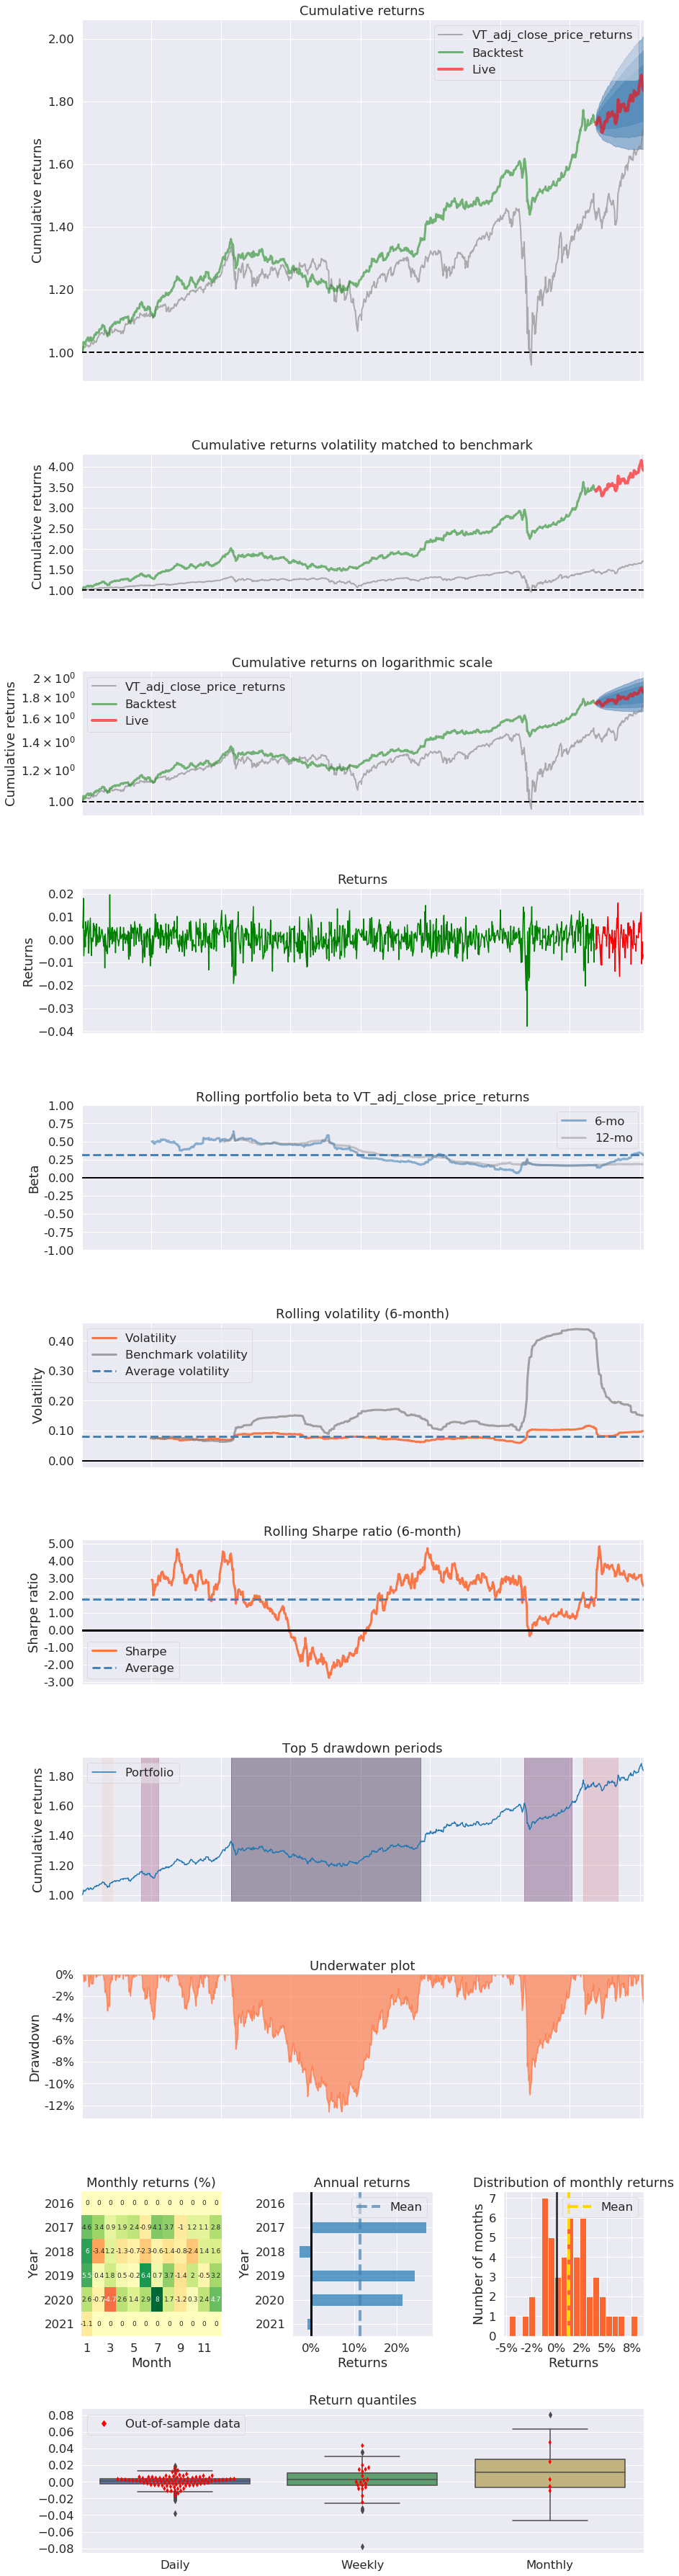

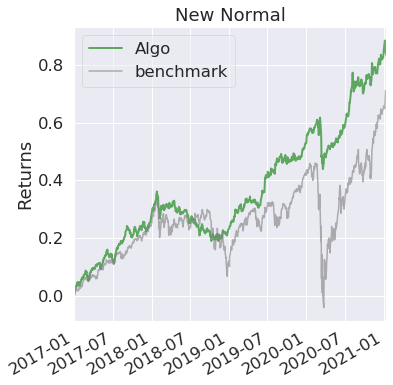

In [46]:
portfolio_return1.index = portfolio_return1.index.tz_localize('US/Eastern')
portfolio_return2.index = portfolio_return2.index.tz_localize('US/Eastern')
benchmark_return.index = benchmark_return.index.tz_localize('US/Eastern')
pyfolio.create_full_tear_sheet(portfolio_return1, benchmark_rets=benchmark_return, live_start_date = '2020-09-08') 

### Plotting the weights of asset class

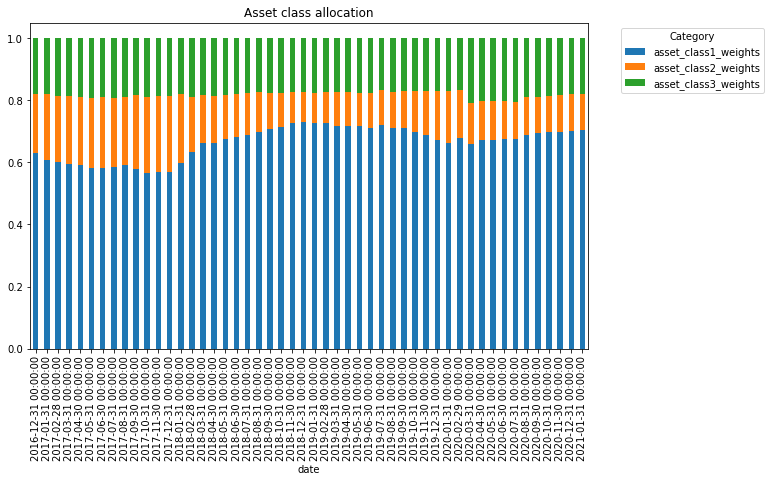

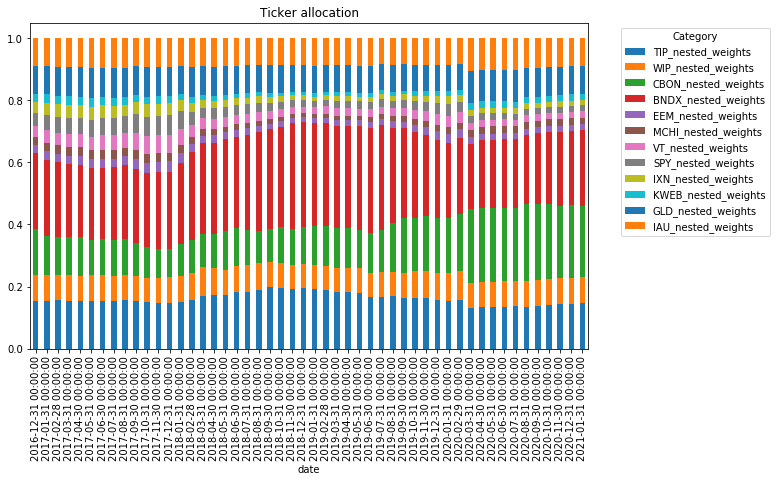

In [47]:
asset_class_weights = results[['asset_class1_weights','asset_class2_weights','asset_class3_weights']]
asset_class_weights  = asset_class_weights.astype(float)
asset_class_weights = asset_class_weights.resample('M').last().ffill()    
asset_class_weights.plot.bar(stacked=True, figsize=(10, 6), title='Asset class allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

ticker_weights = results[['TIP_nested_weights','WIP_nested_weights', 'CBON_nested_weights', 'BNDX_nested_weights',
                          'EEM_nested_weights','MCHI_nested_weights', 'VT_nested_weights', 'SPY_nested_weights',
                          'IXN_nested_weights','KWEB_nested_weights','GLD_nested_weights','IAU_nested_weights' 
                          ]]
ticker_weights  = ticker_weights.astype(float)
ticker_weights = ticker_weights.resample('M').last().ffill()    
ticker_weights.plot.bar(stacked=True, figsize=(10, 6), title='Ticker allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:298.0
-8.682810088160908 1.6245844100217897 1.9221503396300186 8.39576338084691 -1.5931591325159906 13.143321141168716
Volatility target: 0.1, Leverage: 1.0
(-8.682810088160908, 1.6245844100217897, 1.9221503396300186, 8.39576338084691, -1.5931591325159906, 13.143321141168716)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************] 

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:606.0
-12.751065573239133 1.7575625354186966 2.2775458652182516 16.403455899549435 -0.9199259907206052 5.2389813007720525
Volatility target: 0.12000000000000001, Leverage: 1.9999999999999998
(-12.751065573239133, 1.7575625354186966, 2.2775458652182516, 16.403455899549435, -0.9199259907206052, 5.2389813007720525)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*************

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:336.0
-14.486316879123066 1.679552809351064 2.063232867131835 15.400409179042285 -1.2396233924592233 8.455695268724813
Volatility target: 0.16000000000000003, Leverage: 1.7999999999999998
(-14.486316879123066, 1.679552809351064, 2.063232867131835, 15.400409179042285, -1.2396233924592233, 8.455695268724813)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*******************

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:282.0
-14.692699277301319 1.5915580938564002 1.8527300871052947 13.559916776217996 -1.7033055871518603 15.191017467032715
Volatility target: 0.2, Leverage: 1.5999999999999999
(-14.692699277301319, 1.5915580938564002, 1.8527300871052947, 13.559916776217996, -1.7033055871518603, 15.191017467032715)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%****

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:244.0
-14.770674319551242 1.5500391527463804 1.765365270179715 12.2119053554683 -1.70717544552041 18.213741534335444
Volatility target: 0.24000000000000002, Leverage: 1.4
(-14.770674319551242, 1.5500391527463804, 1.765365270179715, 12.2119053554683, -1.70717544552041, 18.213741534335444)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%*************

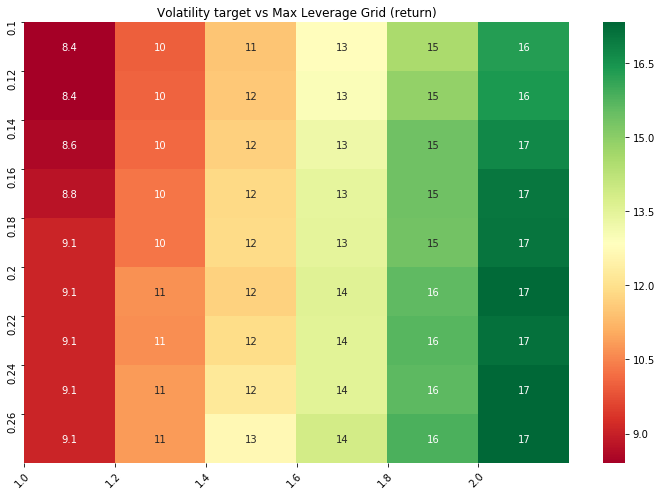

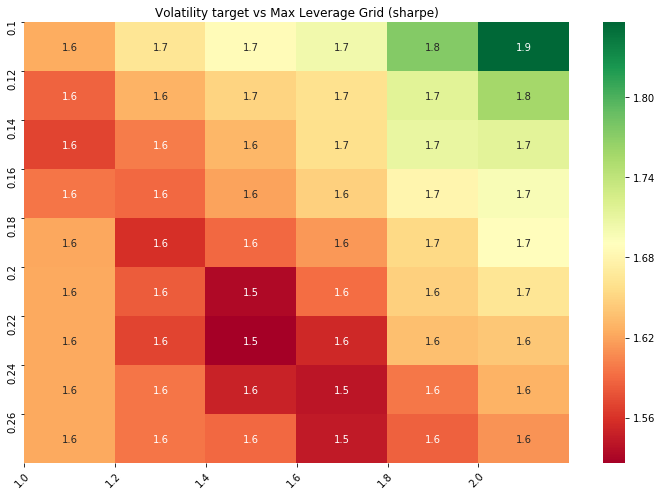

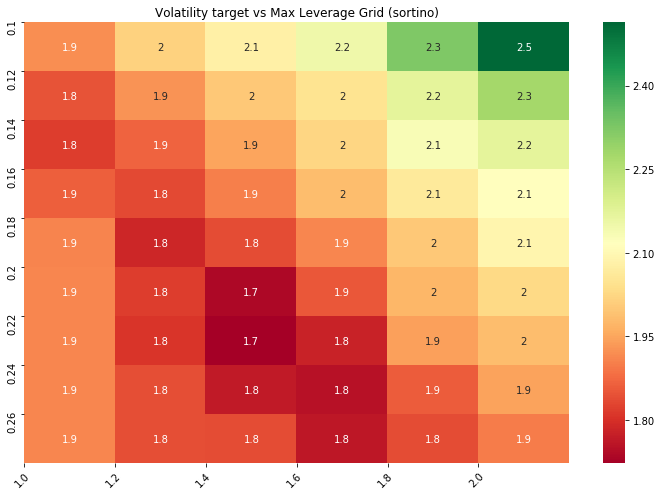

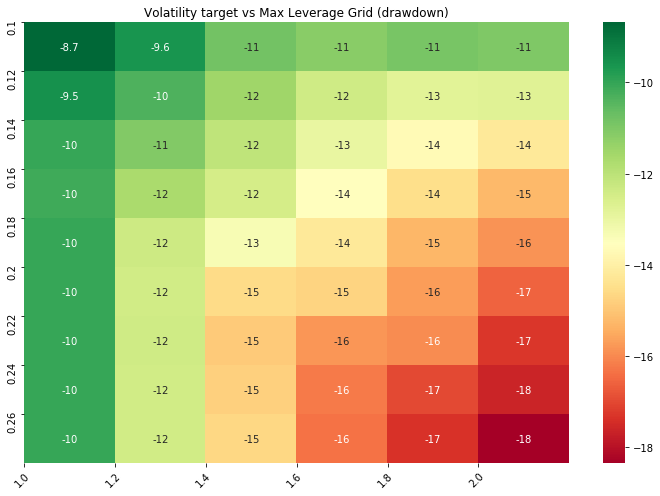

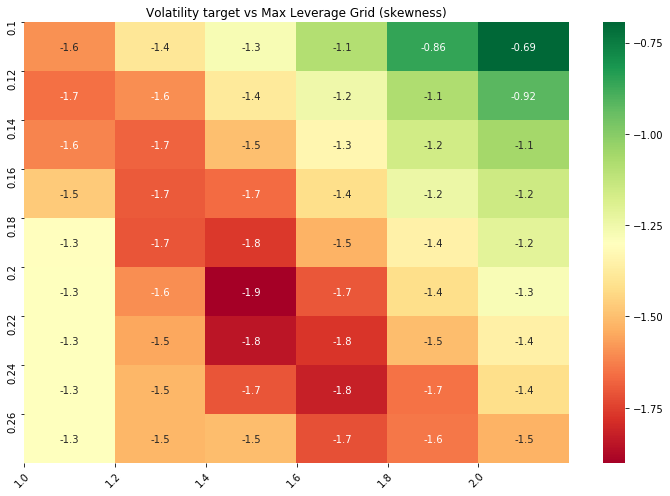

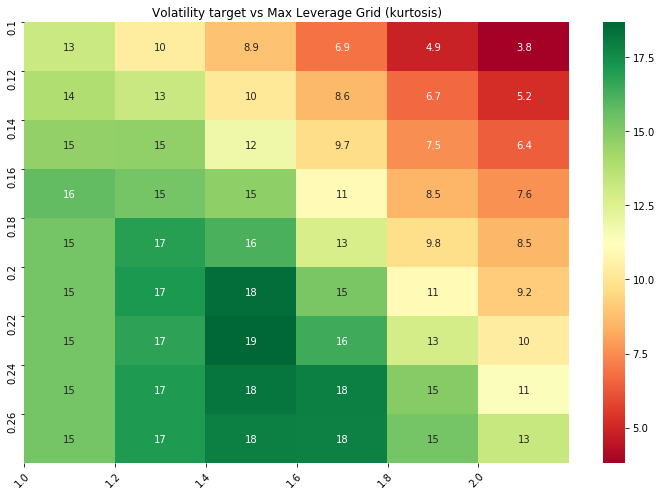

In [38]:
strategy.sensitivity_analysis()
strategy.plot_grid('return')
strategy.plot_grid('sharpe')
strategy.plot_grid('sortino')    
strategy.plot_grid('drawdown')
strategy.plot_grid('skewness')
strategy.plot_grid('kurtosis')  

## Weekly correlation matrix

In [48]:
asset_class_dict =  {'asset_class1': ['TIP', 'WIP', 'CBON', 'BNDX'],
                     'asset_class2': ['EEM','MCHI','VT','SPY', 'IXN', 'KWEB'], 
                     'asset_class3': ['GLD','IAU']}

start_date = '2015-01-01'
end_date = '2050-12-31'
api = 'yfinance'
freq = 'W'
window = 252
window_week = 52
volatility_targeting = 0.1
volatility_targeting_lookback = 36
max_leverage = 2.0         
perc_diff_before_rebalancing = 0.15  
comm_fee = 2
financing_fee = 0.015
leverage = 'partial'    #leverage: full or partial
starting_amount = 1000000                
volatility_targets = np.arange(0.1,0.28,0.02)
max_leverage_targets = np.arange(1, 2.1, 0.2) 

In [49]:
strategy_week = rp.risk_parity_sensitivity_forecast(asset_class_dict, 
                                            start_date, end_date,
                                            api, freq, window, window_week,
                                            volatility_targeting, volatility_targeting_lookback,
                                            max_leverage, perc_diff_before_rebalancing,
                                            comm_fee, financing_fee, leverage,
                                            starting_amount,
                                            volatility_targets, max_leverage_targets
                                            )    

strategy_week.get_risk_parity_df(0.1, 2.0) 
results_week = strategy_week.df

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed


/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'] = np.nan; price_weights['portfolio_value'][0] = starting_amount
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'][t] = sum(price_weights.loc[price_weights.index[t], ticker_val])
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

Run after volatility targeted portfolio
Total comm:1140.0
-10.901138122709346 1.915012290333808 2.600912192266355 17.28476144258735 -0.6805271461553524 3.5133374218946365


In [50]:
sharpe_weekly_cor = ut.get_sharpe(results_week['portfolio_vol_return'])
sortino_weekly_cor = ut.get_sortino(results_week['portfolio_vol_return'])
ret_weekly_cor = empyrical.annual_return(results_week['portfolio_vol_return'], period='daily')
sd_weekly_cor = empyrical.annual_volatility(results_week['portfolio_vol_return'], period='daily')    
drawdown_weekly_cor = empyrical.max_drawdown(results_week['portfolio_vol_return'])
calmar_weekly_cor = empyrical.calmar_ratio(results_week['portfolio_vol_return'], period='daily')   

performance = performance.append({'strategy': 'Weekly correlation matrix performance', 
                                  'sharpe': sharpe_weekly_cor,
                                  'sortino': sortino_weekly_cor,
                                  'annualized_returns': ret_weekly_cor,
                                  'annualized_sd': sd_weekly_cor,
                                  'max_drawdown': drawdown_weekly_cor,
                                  'calmar_ratio': calmar_weekly_cor
                                  }, ignore_index=True)

performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio,sortino
0,Daily correlation matrix performance,1.856001,0.162740,0.083210,-0.125893,1.292679,2.513572
1,Weekly correlation matrix performance,1.915012,0.172663,0.085177,-0.126378,1.366247,2.600912


In [51]:
portfolio_return1_week = pd.Series(results_week['portfolio_vol_return'])
portfolio_return2_week = pd.Series(results_week['portfolio_return'])
benchmark_return = pd.Series(results_week['VT_adj_close_price_returns'])

portfolio_return1_week.index = portfolio_return1_week.index.tz_localize('US/Eastern')
portfolio_return2_week.index = portfolio_return2_week.index.tz_localize('US/Eastern')
benchmark_return.index = benchmark_return.index.tz_localize('US/Eastern')

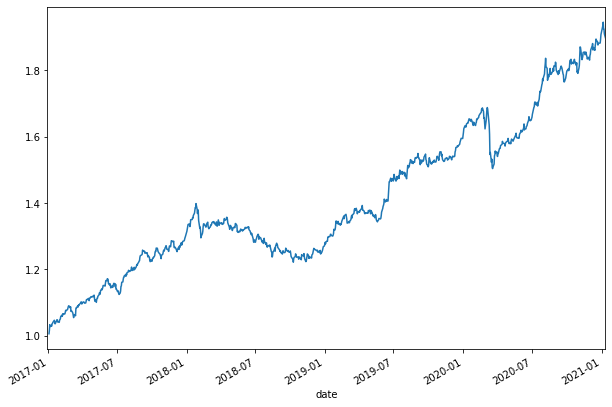

In [52]:
(1+portfolio_return1_week).cumprod().plot()

/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.64,2018-01-26,2018-10-10,2019-06-07,356
1,10.90,2020-03-05,2020-03-19,2020-07-06,88
2,4.05,2017-06-06,2017-07-07,2017-07-19,32
3,3.89,2020-08-06,2020-09-24,2020-11-04,65
4,3.76,2020-02-21,2020-02-28,2020-03-05,10


Stress Events,mean,min,max
New Normal,0.06%,-3.81%,2.01%


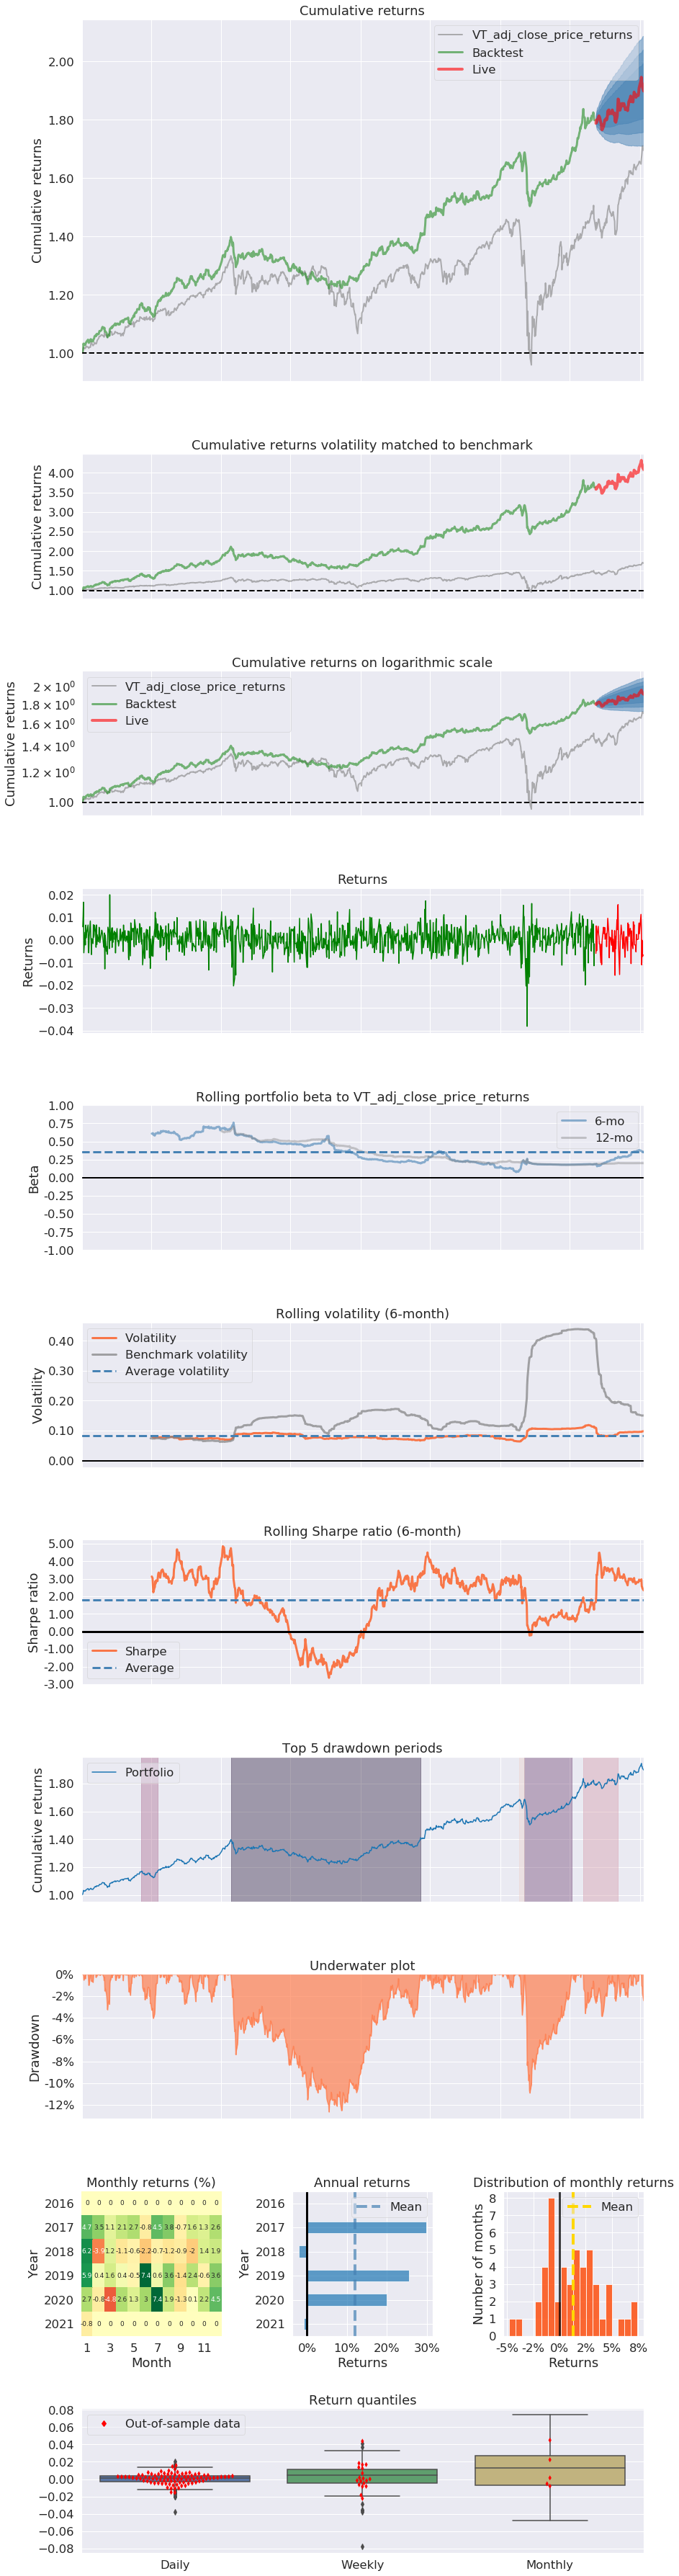

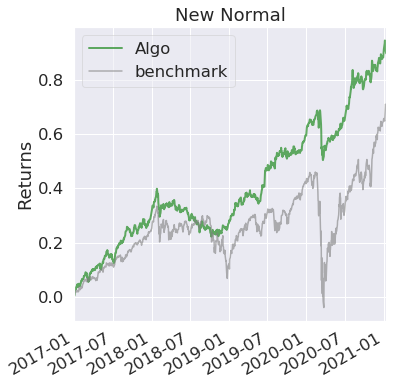

In [53]:
livedate = pd.Timestamp('2020-09-08').tz_localize('US/Eastern')
livedate
portfolio_return1_week.index
pyfolio.create_full_tear_sheet(portfolio_return1_week, benchmark_rets=benchmark_return, live_start_date = livedate) 

### Plotting the weights of asset class

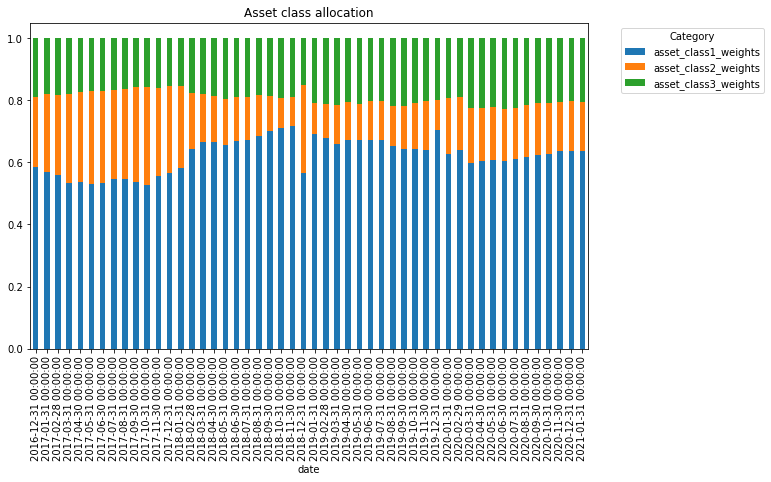

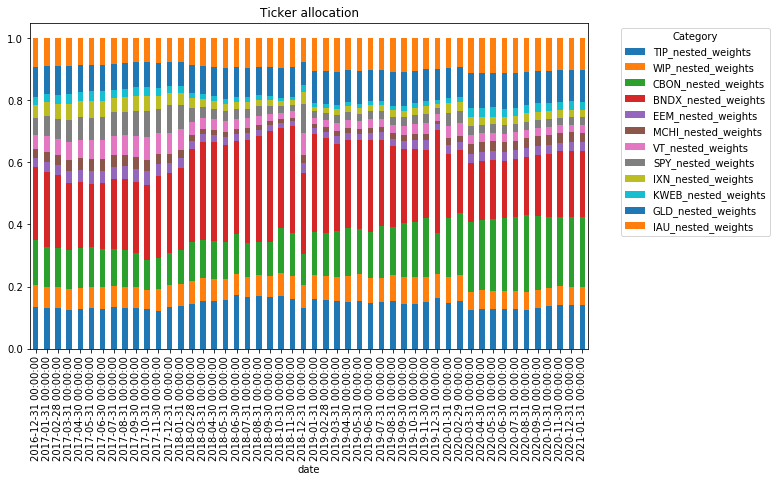

In [55]:
asset_class_weights_week = results_week[['asset_class1_weights','asset_class2_weights','asset_class3_weights']]
asset_class_weights_week  = asset_class_weights_week.astype(float)
asset_class_weights_week = asset_class_weights_week.resample('M').last().ffill()    
asset_class_weights_week.plot.bar(stacked=True, figsize=(10, 6), title='Asset class allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

ticker_weights_week = results_week[['TIP_nested_weights','WIP_nested_weights', 'CBON_nested_weights', 'BNDX_nested_weights',
                          'EEM_nested_weights','MCHI_nested_weights', 'VT_nested_weights', 'SPY_nested_weights',
                          'IXN_nested_weights','KWEB_nested_weights','GLD_nested_weights','IAU_nested_weights' 
                          ]]
ticker_weights_week  = ticker_weights_week.astype(float)
ticker_weights_week = ticker_weights_week.resample('M').last().ffill()    
ticker_weights_week.plot.bar(stacked=True, figsize=(10, 6), title='Ticker allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:438.0
-8.368759899780452 1.7261084644932165 2.0823003234107262 9.481381174782854 -1.3046233102331328 10.497971464252284
Volatility target: 0.1, Leverage: 1.0
(-8.368759899780452, 1.7261084644932165, 2.0823003234107262, 9.481381174782854, -1.3046233102331328, 10.497971464252284)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:864.0
-12.603129003763705 1.8831647578964474 2.4857375071045578 18.46863097921496 -0.797314014441659 4.456902931444471
Volatility target: 0.12000000000000001, Leverage: 1.9999999999999998
(-12.603129003763705, 1.8831647578964474, 2.4857375071045578, 18.46863097921496, -0.797314014441659, 4.456902931444471)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*******************

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:482.0
-14.124704980203918 1.7561476830046159 2.1831607996492877 17.06209744923064 -1.0565353683811725 7.11327952709867
Volatility target: 0.16000000000000003, Leverage: 1.7999999999999998
(-14.124704980203918, 1.7561476830046159, 2.1831607996492877, 17.06209744923064, -1.0565353683811725, 7.11327952709867)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*******************

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:448.0
-14.07337738277057 1.6976046877674031 2.029719955107322 15.300698554979242 -1.351492528097657 11.366580997650821
Volatility target: 0.2, Leverage: 1.5999999999999999
(-14.07337738277057, 1.6976046877674031, 2.029719955107322, 15.300698554979242, -1.351492528097657, 11.366580997650821)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%**********

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
Run after volatility targeted portfolio
Total comm:362.0
-14.013984472737764 1.635886361580052 1.9145464203936253 13.693271674852658 -1.2183049557499552 14.998016742358597
Volatility target: 0.24000000000000002, Leverage: 1.4
(-14.013984472737764, 1.635886361580052, 1.9145464203936253, 13.693271674852658, -1.2183049557499552, 14.998016742358597)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%*****

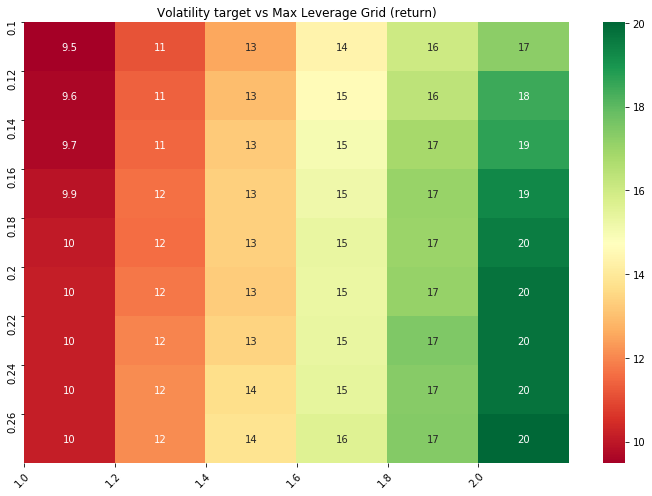

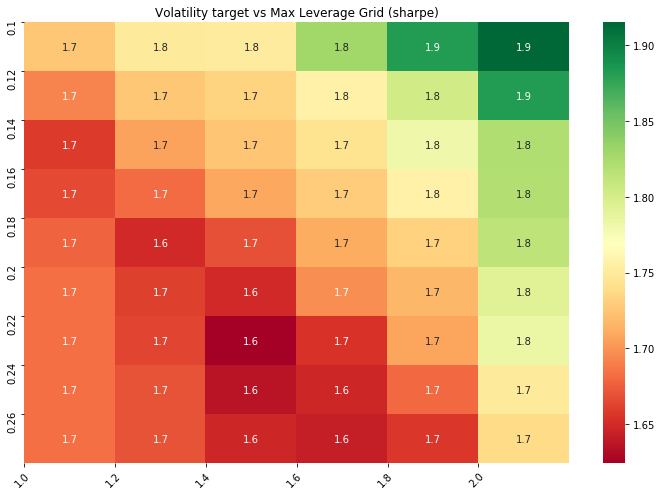

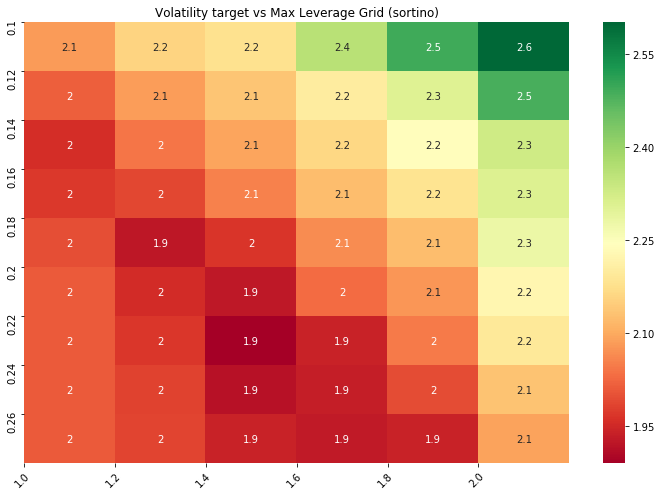

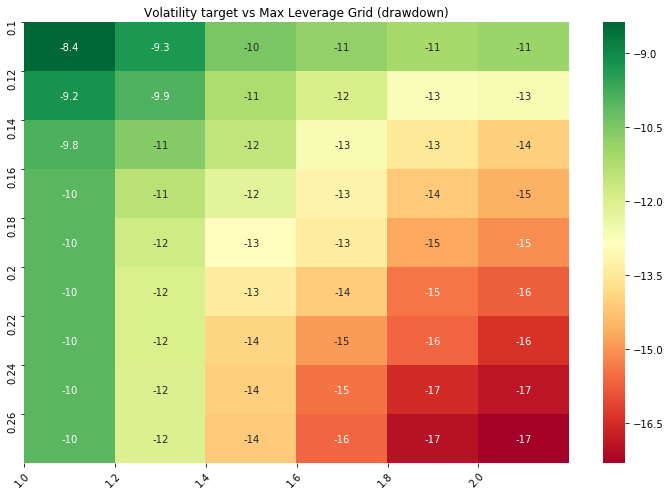

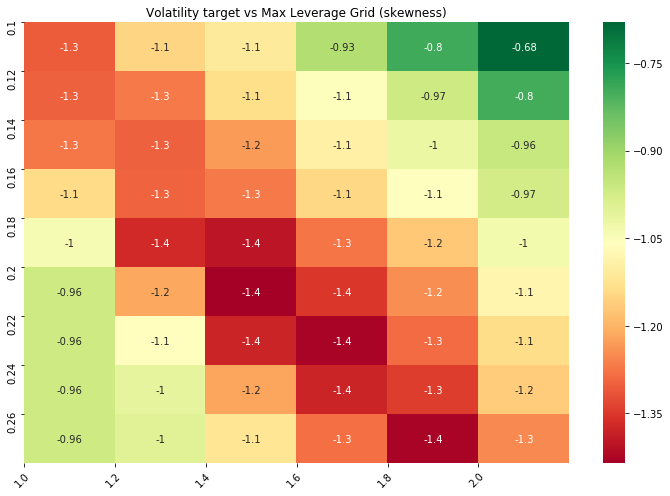

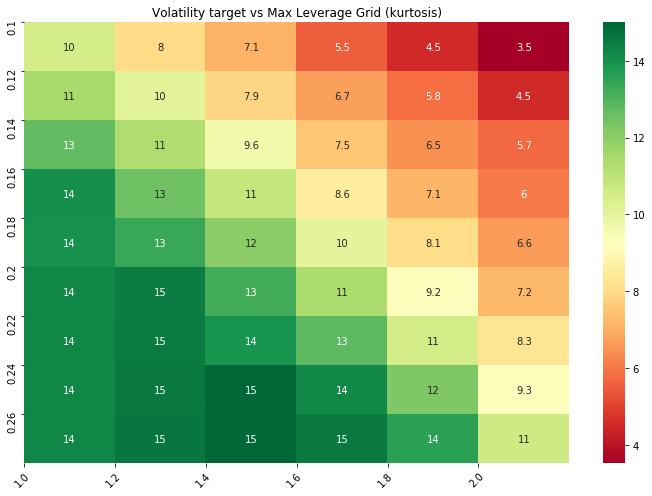

In [39]:
strategy_week.sensitivity_analysis()
strategy_week.plot_grid('return')
strategy_week.plot_grid('sharpe')
strategy_week.plot_grid('sortino')    
strategy_week.plot_grid('drawdown')
strategy_week.plot_grid('skewness')
strategy_week.plot_grid('kurtosis')  

### Exploring alternative grouping of asset classes

In [56]:
asset_class_dict_alt =  {'asset_class1': ['CBON','GLD','TIP','WIP'],
                         'asset_class2': ['EEM','MCHI','VT','SPY', 'IXN', 'KWEB']}

#asset_class_dict_alt = {'asset_class1': ['CBON','BNDX','IGOV'],
#                        'asset_class2': ['EEM','MCHI','VT','SPY', 'IXN', 'KWEB'], 
#                        'asset_class3': ['GLD','IAU', 'TIP', 'WIP']}

start_date = '2015-01-01'
end_date = '2050-12-31'
api = 'yfinance'
freq = 'W'
window = 252
window_week = 52
volatility_targeting = 0.1
volatility_targeting_lookback = 36
max_leverage = 2.0         
perc_diff_before_rebalancing = 0.15  
comm_fee = 2
financing_fee = 0.015
leverage = 'partial'    #leverage: full or partial
starting_amount = 1000000                
volatility_targets = np.arange(0.1,0.16,0.02)
max_leverage_targets = np.arange(1.4, 2.1, 0.2) 

In [57]:
strategy_week_alt = rp.risk_parity_sensitivity_forecast(asset_class_dict_alt, 
                                            start_date, end_date,
                                            api, freq, window, window_week,
                                            volatility_targeting, volatility_targeting_lookback,
                                            max_leverage, perc_diff_before_rebalancing,
                                            comm_fee, financing_fee, leverage,
                                            starting_amount,
                                            volatility_targets, max_leverage_targets
                                            )    

strategy_week_alt.get_risk_parity_df(0.1, 2.0) 
results_week_alt = strategy_week_alt.df

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed


/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'] = np.nan; price_weights['portfolio_value'][0] = starting_amount
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'][t] = sum(price_weights.loc[price_weights.index[t], ticker_val])
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

Run after volatility targeted portfolio
Total comm:1464.0
-15.932046945221522 1.6858597045109935 2.3736325299327063 16.46234372132165 -0.46351101538969475 1.9968250942902213


In [58]:
sharpe_weekly_alt_cor = ut.get_sharpe(results_week_alt['portfolio_vol_return'])
sortino_weekly_alt_cor = ut.get_sortino(results_week_alt['portfolio_vol_return'])
ret_weekly_alt_cor = empyrical.annual_return(results_week_alt['portfolio_vol_return'], period='daily')
sd_weekly_alt_cor = empyrical.annual_volatility(results_week_alt['portfolio_vol_return'], period='daily')    
drawdown_weekly_alt_cor = empyrical.max_drawdown(results_week_alt['portfolio_vol_return'])
calmar_weekly_alt_cor = empyrical.calmar_ratio(results_week_alt['portfolio_vol_return'], period='daily')   

performance = performance.append({'strategy': 'Weekly correlation matrix performance (alt config)', 
                                  'sharpe': sharpe_weekly_alt_cor,
                                  'sortino': sortino_weekly_alt_cor,
                                  'annualized_returns': ret_weekly_alt_cor,
                                  'annualized_sd': sd_weekly_alt_cor,
                                  'max_drawdown': drawdown_weekly_alt_cor,
                                  'calmar_ratio': calmar_weekly_alt_cor
                                  }, ignore_index=True)

performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio,sortino
0,Daily correlation matrix performance,1.856001,0.162740,0.083210,-0.125893,1.292679,2.513572
1,Weekly correlation matrix performance,1.915012,0.172663,0.085177,-0.126378,1.366247,2.600912
2,Weekly correlation matrix performance (alt con...,1.685860,0.164448,0.092990,-0.159320,1.032186,2.373633


In [59]:
portfolio_return1_week_alt = pd.Series(results_week_alt['portfolio_vol_return'])
portfolio_return2_week_alt = pd.Series(results_week_alt['portfolio_return'])
benchmark_return = pd.Series(results_week_alt['VT_adj_close_price_returns'])

portfolio_return1_week_alt.index = portfolio_return1_week_alt.index.tz_localize('US/Eastern')
portfolio_return2_week_alt.index = portfolio_return2_week_alt.index.tz_localize('US/Eastern')
benchmark_return.index = benchmark_return.index.tz_localize('US/Eastern')

/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.93,2018-01-26,2018-10-29,2019-10-24,455
1,11.25,2020-02-19,2020-03-19,2020-07-20,109
2,3.82,2020-09-01,2020-09-24,2020-10-09,29
3,3.17,2017-06-08,2017-07-06,2017-07-14,27
4,3.06,2017-02-24,2017-03-09,2017-03-16,15


Stress Events,mean,min,max
New Normal,0.06%,-3.27%,2.11%


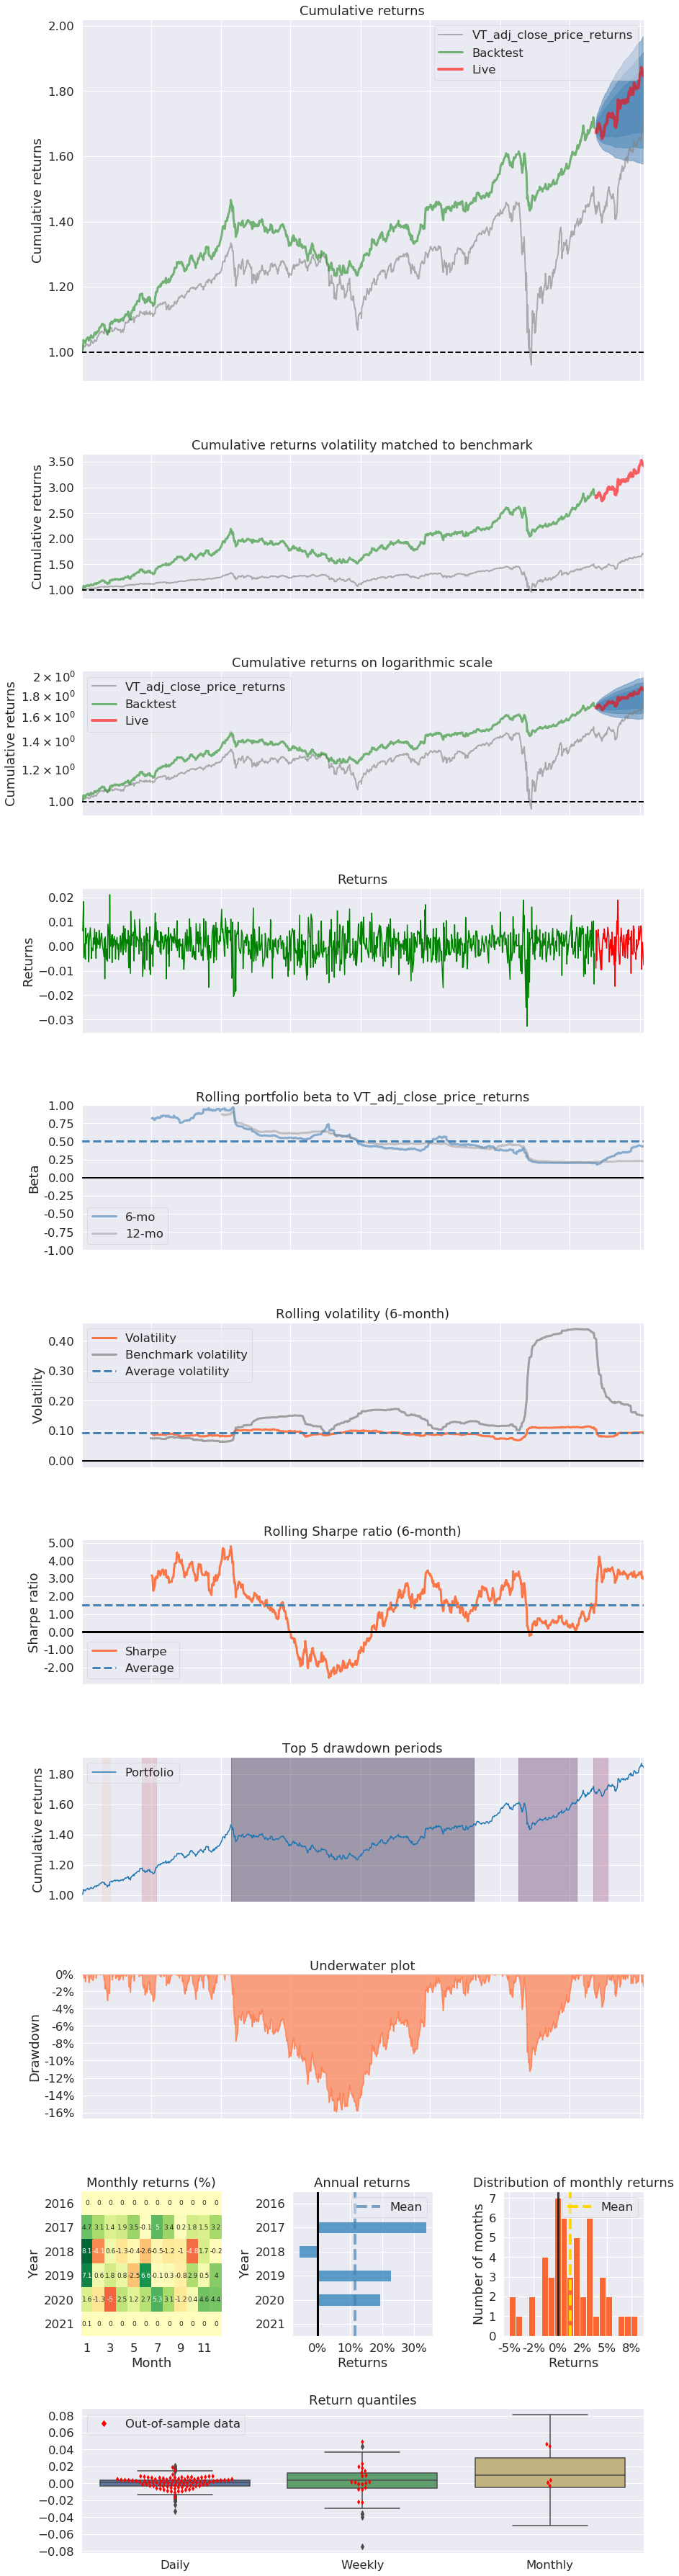

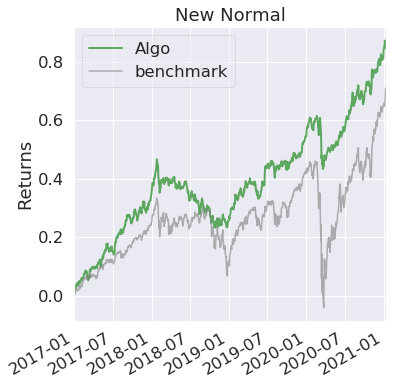

In [60]:
livedate = pd.Timestamp('2020-09-08').tz_localize('US/Eastern')
livedate
portfolio_return1_week_alt.index
pyfolio.create_full_tear_sheet(portfolio_return1_week_alt, benchmark_rets=benchmark_return, live_start_date = livedate) 

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed


/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'] = np.nan; price_weights['portfolio_value'][0] = starting_amount
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_weights['portfolio_value'][t] = sum(price_weights.loc[price_weights.index[t], ticker_val])
/home/jirong/Desktop/household_wealth/risk_parity/risk_parity_class.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

Run after volatility targeted portfolio
Total comm:474.0
-12.62148641433872 1.602012286990263 2.0926730707560615 12.743562743243997 -0.8015377671274819 4.43835569377707
Volatility target: 0.1, Leverage: 1.4
(-12.62148641433872, 1.602012286990263, 2.0926730707560615, 12.743562743243997, -0.8015377671274819, 4.43835569377707)
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  6 of 6 completed
Run after volatility targeted portfolio
Total comm:672.0
-13.834144256779709 1.6520517199230325 2.239367196475654 14.301294947041022 -0.6225020124509826 3.185992083434874
Volatility target: 0.1, Leverage: 1.5999999999999999
(-13.834144256779709, 1.6520517199230325, 2.239367196475654, 14.301294947041022, -0.6225020124509826, 3.185992083434874)
[*********************100%***********************]  4

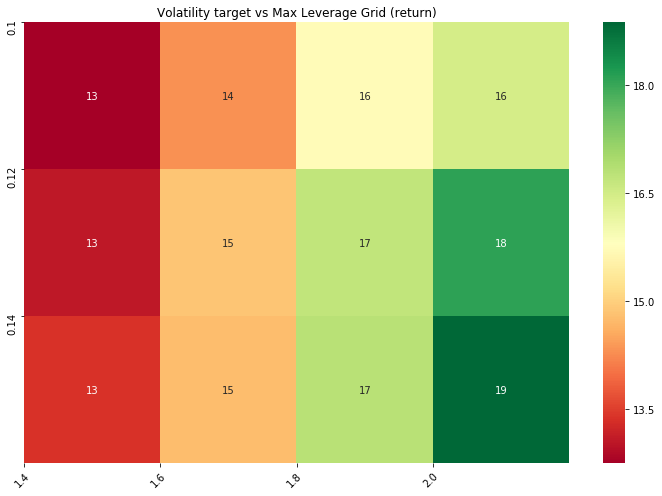

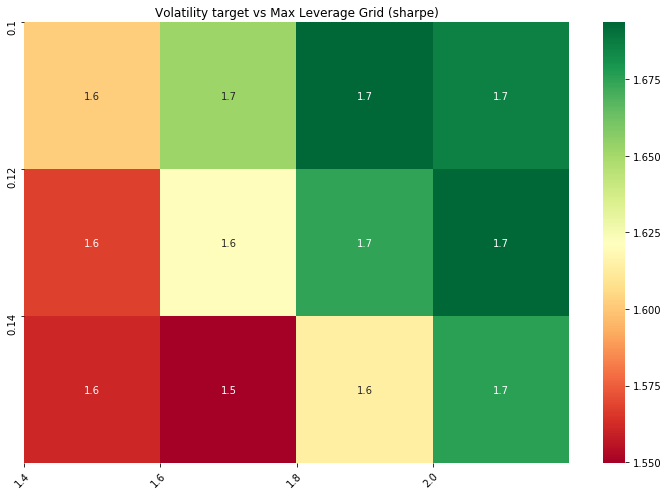

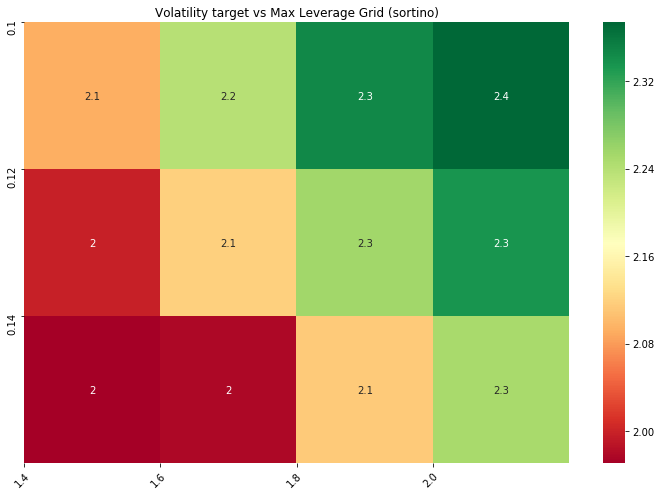

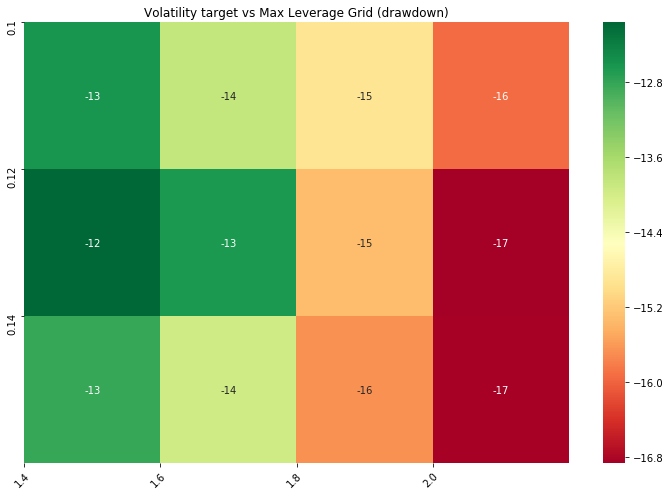

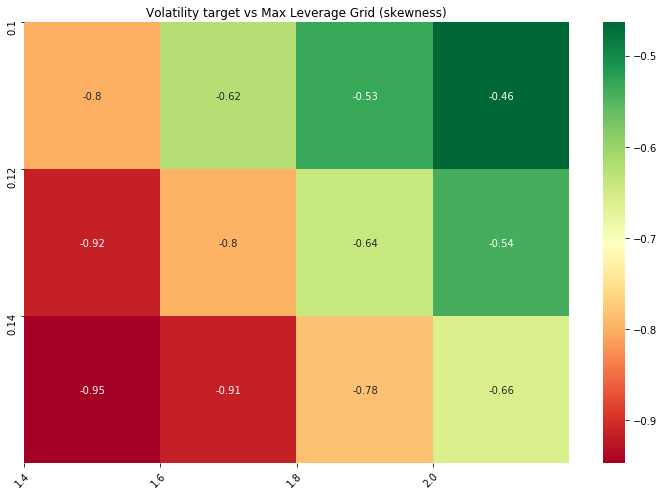

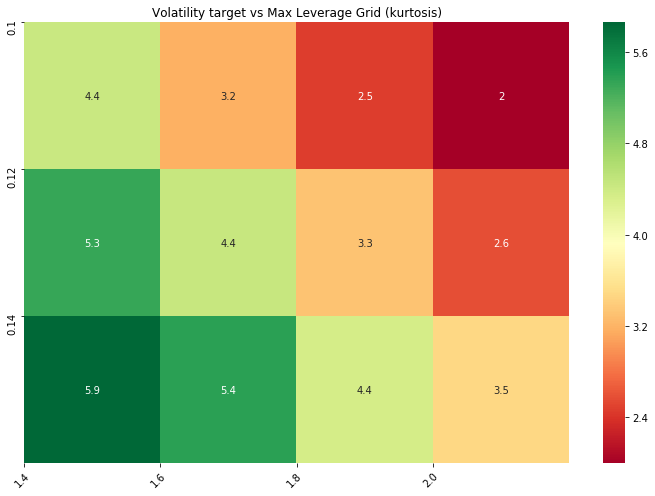

In [37]:
strategy_week_alt.sensitivity_analysis()
strategy_week_alt.plot_grid('return')
strategy_week_alt.plot_grid('sharpe')
strategy_week_alt.plot_grid('sortino')    
strategy_week_alt.plot_grid('drawdown')
strategy_week_alt.plot_grid('skewness')
strategy_week_alt.plot_grid('kurtosis')

## Plotting the weights of asset classes

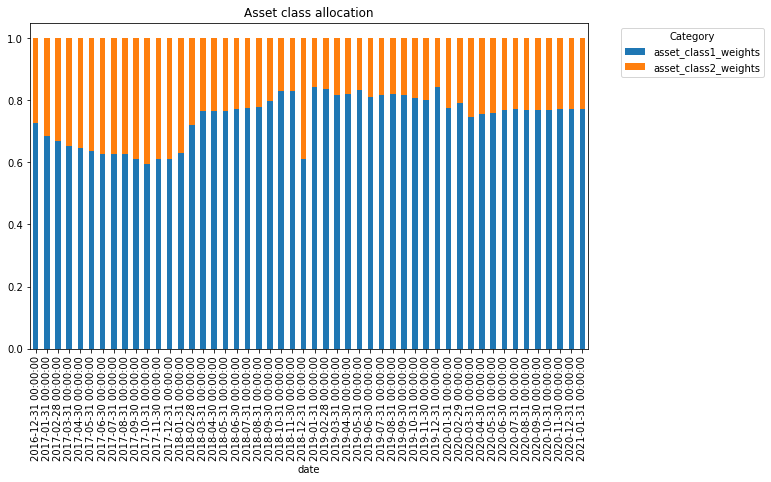

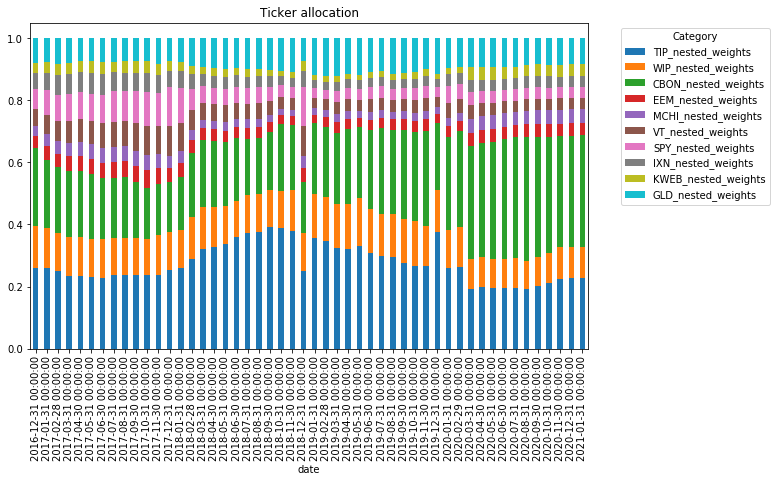

In [63]:
asset_class_weights_week_alt = results_week_alt[['asset_class1_weights','asset_class2_weights']]
asset_class_weights_week_alt  = asset_class_weights_week_alt.astype(float)
asset_class_weights_week_alt = asset_class_weights_week_alt.resample('M').last().ffill()    
asset_class_weights_week_alt.plot.bar(stacked=True, figsize=(10, 6), title='Asset class allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

ticker_weights_week_alt = results_week_alt[['TIP_nested_weights','WIP_nested_weights', 'CBON_nested_weights',
                          'EEM_nested_weights','MCHI_nested_weights', 'VT_nested_weights', 'SPY_nested_weights',
                          'IXN_nested_weights','KWEB_nested_weights','GLD_nested_weights' 
                          ]]
ticker_weights_week_alt  = ticker_weights_week_alt.astype(float)
ticker_weights_week_alt = ticker_weights_week_alt.resample('M').last().ffill()    
ticker_weights_week_alt.plot.bar(stacked=True, figsize=(10, 6), title='Ticker allocation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()    

### Summarised statistics across all 3 configurations

In the 3 different configurations below, the performance characteristics are similar with sharpe between 1.7 to 1.9, annualized returns of 0.16-0.17, calmar ratio of 1.0 to 1.5, sortino of 2.4 to 2.7.

In [30]:
performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio,sortino
0,Daily correlation matrix performance,1.856001,0.162740,0.083210,-0.125893,1.292679,2.513572
1,Weekly correlation matrix performance,1.915012,0.172663,0.085177,-0.126378,1.366247,2.600912
2,Weekly correlation matrix performance (alt con...,1.685860,0.164448,0.092990,-0.159320,1.032186,2.373633


### References

- https://www.bridgewater.com/research-and-insights/the-opening-of-chinese-credit-markets-means-that-foreign-investors-can-build-a-balanced-portfolio-in-china-this-will-be-a-big-deal
- https://www.bridgewater.com/research-and-insights/a-top-down-look-at-the-chinese-equity-market
- https://www.bridgewater.com/research-and-insights/balancing-chinese-assets-offers-a-rare-opportunity-for-investors
- https://www.bridgewater.com/research-and-insights/the-all-weather-story
- https://www.aqr.com/Insights/Research/White-Papers/Understanding-Risk-Parity
- https://www.aqr.com/Insights/Research/White-Papers/Can-Risk-Parity-Outperform-If-Yields-Rise
- https://www.aqr.com/Insights/Research/Journal-Article/Leverage-Aversion-and-Risk-Parity
- https://www.bridgewater.com/grappling-with-the-new-reality-of-zero-bond-yields-virtually-everywhere